In [2]:
from optim_relu_max_linear import OptimReluMaxLinear
from check_grad_optim_v import test_optim_splade_model
import triton
import torch

In [3]:
torch.cuda.is_available()

True

In [3]:
test_optim_splade_model() # oblie ca, elle prend du temps

/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/torch/autograd/__init__.py:394: UserWarning: Error detected in OptimReluMaxLinearVBackward. Traceback of forward call that caused the error:
  File "/usr/local/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/traitlets/config/application.py", line 978, in launch_instance
    app.start()
  File "/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/tornado/pla

FileNotFoundError: [Errno 2] No such file or directory: 'ldconfig'

In [4]:
UPPER_LIMIT = 15  ## change ca pour diminuer la consommation de memoire.
x_vals = []
for i in range(1, UPPER_LIMIT): 
    x_vals.append([2000 * i, 256, 100, 512])

In [5]:
print(x_vals)

[(2000, 256, 100, 512), (4000, 256, 100, 512), (6000, 256, 100, 512), (8000, 256, 100, 512), (10000, 256, 100, 512)]


In [6]:
configs = []

configs.append(
    triton.testing.Benchmark(
        x_names=["V", "B", "L", "D"],  # Argument names to use as an x-axis for the plot
        x_vals=x_vals,  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals= ["torch", "triton"],  # Label name for the lines
        line_names= ["torch", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GB/s",  # Label name for the y-axis
        plot_name="relu_max_backward_performance",
        args={},
    ))


In [7]:
@triton.testing.perf_report(configs)
def benchmark(B, L, D, V, provider):
    x = torch.randn(B, L, D, requires_grad=True, dtype=torch.float64, device='cuda')
    w = torch.randn(D, V, requires_grad=True, dtype=torch.float64, device='cuda')
    b = torch.randn(V, requires_grad=True, dtype=torch.float64, device='cuda')
    list_lengths = torch.randint(0, L, [B])
    mask = torch.ones(B, L).cuda()
    for i, l in enumerate(list_lengths):
        mask[i, l:] = 0
        
    mask_inf = torch.where(mask == 1, 0, -torch.inf)
    relu = torch.nn.ReLU()
    
    torch_calculation = relu(torch.max((x @ w) + b.reshape(1, 1, *b.shape) + mask_inf.reshape(*mask_inf.shape, 1), dim=1)[0])
    triton_calculation = OptimReluMaxLinear.apply(x, w, b, mask)[0]
        
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch_calculation.sum().backward(retain_graph=True), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_calculation.sum().backward(retain_graph=True) , quantiles=quantiles)
    gbps = lambda ms: B * L * D + D * V + V / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

(2000, 256, 100, 512)
(2000, 256, 100, 512)
(4000, 256, 100, 512)
(4000, 256, 100, 512)
(6000, 256, 100, 512)
(6000, 256, 100, 512)
(8000, 256, 100, 512)
(8000, 256, 100, 512)
(10000, 256, 100, 512)
(10000, 256, 100, 512)


ValueError: setting an array element with a sequence.

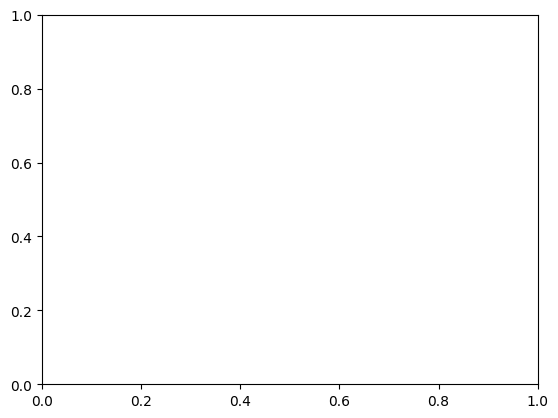

In [8]:
benchmark.run(show_plots=True, print_data=True)